In [24]:
import re
import seaborn as sns
import threading
from tqdm import tqdm
import torch
import pandas as pd

from dataclasses import dataclass, fields, asdict
from model.model import PageAccModel

# Load data

In [28]:
@dataclass
class Page:
    buffer: int
    # is_local_temp: int
    fork_num: int
    block_num: int
    # mode: int
    relam: int
    relfilenode: int
    relhasindex: int
    # relpersistence: int
    relkind: int
    relnatts: int
    relfrozenxid: int
    relminmxid: int
    hit: int

In [29]:
with open("train_data/acc_logfile2", "r") as file:
    data = file.read()

pattern = r"buffer={(\d+)} is_local_temp={(\w+)} fork_num={(\w+)} block_num={(\d+)} mode={(\w+)} strategy={} relam={(\d+)} relfilenode={(\d+)} relhasindex={(\w+)} relpersistence={(\w+)} relkind={(\w+)} relnatts={(\d+)} relfrozenxid={(\d+)} relminmxid={(\d+)} hit={(\w+)}"
matches = re.findall(pattern, data)

pages = []

for match in matches:
    buffer = int(match[0])
    is_local_temp = 1 if match[1] == "true" else 0
    fork_num = ["MAIN_FORKNUM", "FSM_FORKNUM", "VISIBILITYMAP_FORKNUM", "INIT_FORKNUM"].index(match[2])
    block_num = int(match[3])
    mode = ["RBM_NORMAL", "RBM_ZERO_AND_LOCK", "RBM_ZERO_AND_CLEANUP_LOCK", "RBM_ZERO_ON_ERROR", "RBM_NORMAL_NO_LOG"].index(match[4])
    relam = int(match[5])
    relfilenode = int(match[6])
    relhasindex = 1 if match[7] == "true" else 0
    relpersistence = ["p", "u", "t"].index(match[8])
    relkind = ["r", "i", "S", "t", "v", "m", "c", "f", "p", "I"].index(match[9])
    relnatts = int(match[10])
    relfrozenxid = int(match[11])
    relminmxid = int(match[12])
    hit = 1 if match[13] == "true" else 0

    page = Page(
        buffer,
        # is_local_temp, 
        fork_num,
        block_num,
        #mode,
        relam,
        relfilenode,
        relhasindex,
        # relpersistence,
        relkind,
        relnatts,
        relfrozenxid,
        relminmxid,
        hit,
    )
    pages.append(page)

In [4]:
with open("train_data/acc_logfile2_pages", "w") as f:
    for page in pages:
        f.write(f"{page.buffer}\n")


In [5]:
print(len(pages))

1024067


In [6]:
optimal_results = []
with open("train_data/acc_logfile2_victims", "r") as f:
    line = f.readline()
    while line:
        victims_count = int(line)
        victims_rates = []
        for _ in range(victims_count):
            victim_rate = f.readline().strip().split()
            victims_rates.append([int(victim_rate[0]), int(victim_rate[1])])

        optimal_results.append(victims_rates)
        line = f.readline()

In [7]:
len(optimal_results)

1024067

In [8]:
TRAIN_SIZE = len(pages)
BATCH_SIZE = 2048
BUFFER_SIZE = 32

In [9]:
TRAIN_SIZE

1024067

# Analyse data

In [10]:
sum([page.hit for page in pages[:TRAIN_SIZE]]) / TRAIN_SIZE

0.6318912727389907

In [11]:
# find_optimal_hit_rate([page.buffer for page in pages[:TRAIN_SIZE]], BUFFER_SIZE)
sum([1 if len(victims) == 0 else 0 for victims in optimal_results[:TRAIN_SIZE]]) / TRAIN_SIZE

0.6844718167854251

<Axes: ylabel='Count'>

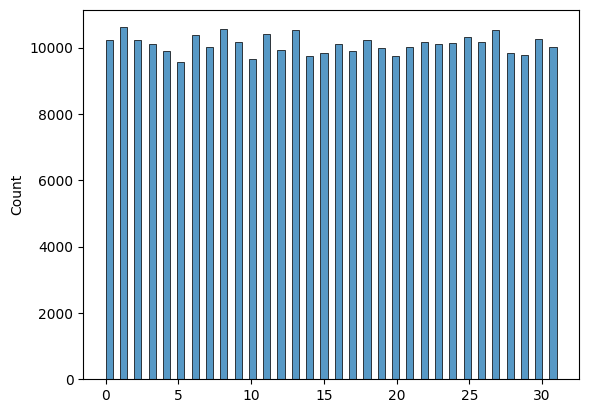

In [12]:
sns.histplot([victims[0][0] for victims in optimal_results[:TRAIN_SIZE] if len(victims) != 0])

<Axes: xlabel='None'>

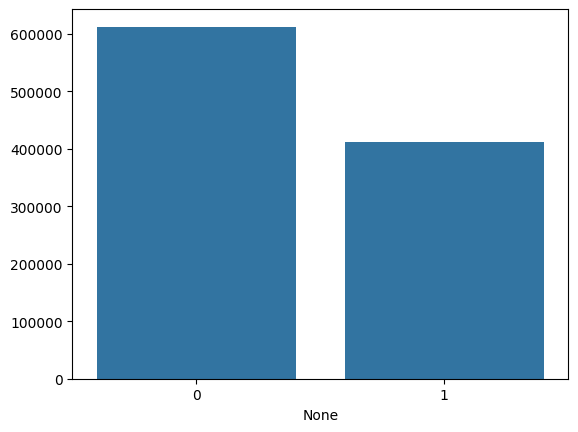

In [33]:
# sns.histplot([page.is_local_temp for page in pages], discrete=True)
# sns.histplot([page.mode for page in pages], discrete=True)

# sns.histplot([page.relam for page in pages], discrete=True)
data = pd.Series([page.relminmxid for page in pages])
value_counts = data.value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)


# Train

In [38]:
def get_model_optimal_res(pages, buffer, current_index):
    res = [0] * (len(buffer) + 1)
    if (current_index >= len(pages)):
        print(f"ERROR: current_index=={current_index} pages.size() == {len(pages)}")

    already_in_buf = any(buf.buffer == pages[current_index].buffer for buf in buffer)
    if already_in_buf:
        res[-1] = 1
        return res, -1
    
    empty_pages = [index for index, value in enumerate(buffer) if value.buffer == -1]
    if len(empty_pages) > 0:
        for i in empty_pages:
            res[i] = 1 / len(empty_pages)
        
        return res, empty_pages[0]
    
    #victim = find_optimal_victim(pages, [page.buffer for page in buffer], current_index)
    victims_rates = optimal_results[current_index]
    victim_rates_sum = sum([victim[1] for victim in victims_rates])
    for victim, rate in victims_rates:
        res[victim] = rate / victim_rates_sum

    return res, victims_rates[0][0]

In [51]:
def get_train_data(pages, buffer, batch_start, batch_end):
    pages_acc = torch.Tensor([list(asdict(page).values()) for page in pages[batch_start:batch_end]])

    buffers = []
    optimal_predictions = []

    for i in range(batch_start, batch_end):
        if i == TRAIN_SIZE:
            print(f"STRANGE: i=={i} bathc_end=={batch_end}")

        buffers.append([value for obj in buffer for value in asdict(obj).values()])

        res, victim = get_model_optimal_res(pages, buffer, i)
        optimal_predictions.append(res)

        if victim >= 0:
            buffer[victim] = pages[i]
            buffer[victim].hit = True
            pages_acc[i - batch_start][-1] = False
        else:
            pages_acc[i - batch_start][-1] = True
    
    return pages_acc, torch.Tensor(buffers), torch.Tensor(optimal_predictions), buffer


In [45]:
model = PageAccModel(len(fields(Page)), 32, BUFFER_SIZE)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

h, c = None, None
model.train()
for epoch in range(5):
    buffer = [Page(-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0)] * BUFFER_SIZE

    loss_sum = 0
    pbar = tqdm(range(0, TRAIN_SIZE, BATCH_SIZE))
    for i in pbar:
        batch_start = i
        # batch_end = i + BATCH_SIZE if i + BATCH_SIZE < TRAIN_SIZE else TRAIN_SIZE
        batch_end = i + BATCH_SIZE
        if batch_end >= TRAIN_SIZE:
            continue
        pages_acc, buffers, optimal_predictions, buffer = get_train_data(pages, buffer, batch_start, batch_end)
    
        optimizer.zero_grad()
    
        out, h, c = model.forward(pages_acc, buffers, h, c)
        # print(out)
    
        loss_value = loss(out, optimal_predictions)
    
        loss_value.backward()
        optimizer.step()
    
        h = h.detach()
        c = c.detach()

        loss_sum += loss_value.item()
        loss_avg = loss_sum / (batch_end // BATCH_SIZE)

        pbar.set_postfix_str(f"loss={loss_avg}")

 82%|████████▏ | 409/501 [05:21<01:12,  1.27it/s, loss=2.863039978558976] 


KeyboardInterrupt: 

# **TEST**

In [133]:
model.eval()

PageAccModel(
  (_page_acc_enc): Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
  )
  (_lstm): LSTM(32, 32, batch_first=True)
  (_buf_page_enc): Sequential(
    (0): Linear(in_features=448, out_features=1024, bias=True)
    (1): ReLU()
  )
  (_page_evict): Sequential(
    (0): Linear(in_features=1056, out_features=33, bias=True)
    (1): Softmax(dim=1)
  )
)

In [50]:
h, c = None, None
buffer = [Page(-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)] * BUFFER_SIZE

hits = 0

loss_sum = 0
step = 1
pbar = tqdm(range(0, 100, step))
for i in pbar:
    batch_start = i
    # batch_end = i + BATCH_SIZE if i + BATCH_SIZE < TRAIN_SIZE else TRAIN_SIZE
    batch_end = i + step 
    if batch_end >= TRAIN_SIZE:
        continue
    pages_acc, buffers, optimal_predictions, buffer = get_train_data(pages, buffer, batch_start, batch_end)
    hits += hits_count

    out, h, c = model.forward(pages_acc, buffers, h, c)
    print("==================")
    print(out)
    print(optimal_predictions)
    print("==================")

    loss_value = loss(out, optimal_predictions)

    loss_sum += loss_value.item()
    loss_avg = loss_sum / (batch_end // step)

    pbar.set_postfix_str(f"loss={loss_avg}")

print(f"hit rate {hits / len(pbar)}")

 73%|███████▎  | 73/100 [00:00<00:00, 366.24it/s, loss=3.0541157983753777]

tensor([[1.0576e-07, 6.9543e-07, 2.7547e-08, 1.1713e-07, 4.9775e-08, 1.2914e-07,
         1.2513e-07, 1.1280e-07, 2.3495e-07, 7.7850e-07, 1.4121e-07, 1.3179e-07,
         9.5770e-08, 1.5972e-07, 2.8003e-07, 1.4653e-07, 1.3451e-07, 1.9367e-05,
         1.2549e-07, 1.1390e-07, 5.3456e-08, 1.7795e-07, 2.1507e-07, 1.1796e-06,
         2.2322e-07, 7.7013e-08, 7.4431e-08, 1.5174e-07, 2.0315e-07, 2.0360e-07,
         8.9978e-09, 8.8734e-08, 9.9997e-01]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
         0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0000]])
tensor([[8.7579e-10, 5.3650e-09, 1.6056e-10, 7.9616e-10, 4.0915e-10, 5.5256e-10,
         6.2544e-10, 6.2721e-10, 1.0848e-09, 5.1453e-09, 6.1149e-10, 4.2770e-10,
         3.8709e-10, 4.8108e-10, 7.9430e-10, 7.1809e-10,

100%|██████████| 100/100 [00:00<00:00, 364.69it/s, loss=2.977266483306885]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0